In [21]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

In [ ]:
# IoU 계산 함수
def compute_iou(box1, box2):
    """
    box: [x1, y1, x2, y2]
    """
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    inter_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0.0


def yolo_to_xyxy(box, img_w, img_h):
    """YOLO 형식 (cx, cy, w, h) → (x1, y1, x2, y2)"""
    cx, cy, w, h = box
    x1 = (cx - w/2) * img_w
    y1 = (cy - h/2) * img_h
    x2 = (cx + w/2) * img_w
    y2 = (cy + h/2) * img_h
    return [x1, y1, x2, y2]

# 경로 설정
image_dir = Path("/workspaces/mask_recognition/data/dataset_1and2/images")
label_dir = Path("/workspaces/mask_recognition/data/dataset_1and2/labels")
model_path = "/workspaces/mask_recognition/results/runs/baseline2/baseline2/weights/best.pt"

# 모델 불러오기
model = YOLO(model_path)

# 평균 IoU 저장용 리스트
image_ious = []

# 모든 이미지에 대해 추론
for img_path in tqdm(sorted(image_dir.glob("*.jpg"))):
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    # 라벨 파일 불러오기
    label_path = label_dir / (img_path.stem + ".txt")
    if not label_path.exists():
        continue

    gt_boxes = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            box = list(map(float, parts[1:5]))  # YOLO 형식 (cx, cy, w, h)
            gt_boxes.append(yolo_to_xyxy(box, w, h))

    # 모델 추론
    results = model.predict(source=str(img_path), save=False, conf=0.25, iou=0.5, verbose=False)
    pred_boxes = []
    for r in results:
        for box in r.boxes.xyxy.cpu().numpy():
            pred_boxes.append(box.tolist())

    # IoU 계산
    ious = []
    for gt in gt_boxes:
        best_iou = 0.0
        for pred in pred_boxes:
            iou = compute_iou(gt, pred)
            if iou > best_iou:
                best_iou = iou
        ious.append(best_iou)  # GT box 당 best IoU

    # 이미지당 평균 IoU
    if ious:
        image_ious.append(np.mean(ious))

100%|██████████| 1773/1773 [05:30<00:00,  5.36it/s]


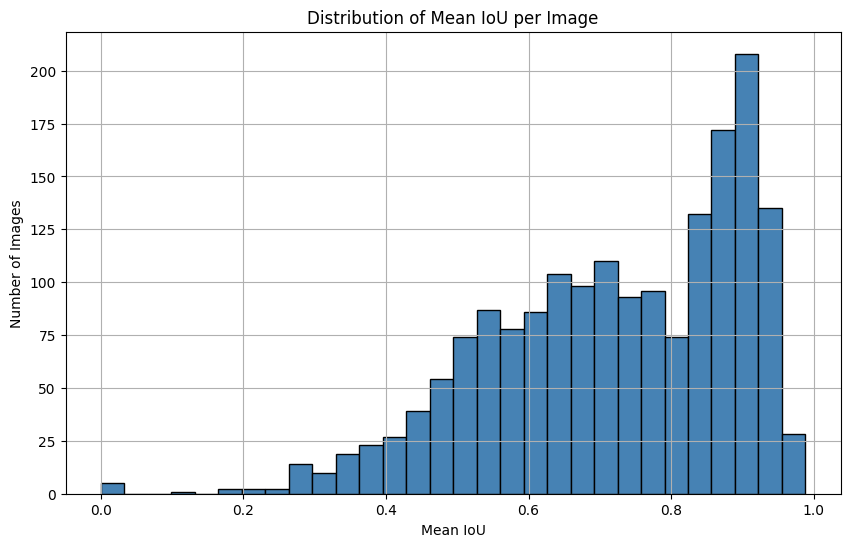

In [3]:
# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(image_ious, bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution of Mean IoU per Image")
plt.xlabel("Mean IoU")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()

In [5]:
len(image_ious)

1773

In [8]:
image_ious_array = np.array(image_ious)

In [ ]:
sum(image_ious_array > 0.7)

1030

In [15]:
# 고품질 이미지만 선택
THRESH = 0.7
high_quality_indices = [i for i, iou in enumerate(image_ious) if iou >= THRESH]

In [ ]:
high_quality_indices

In [20]:
print(f"ratio of selected data from dataset1: {sum(np.array(high_quality_indices) <= 920) * 100 / 920:.2f}%")
print(f"ratio of selected data from dataset2: {sum(np.array(high_quality_indices) > 920) * 100 / 853:.2f}%")

ratio of selected data from dataset1: 88.70%
ratio of selected data from dataset2: 25.09%


In [ ]:
image_dir = Path("/workspaces/mask_recognition/data/dataset_1and2/images")
label_dir = Path("/workspaces/mask_recognition/data/dataset_1and2/labels")

In [26]:
image_paths = sorted(image_dir.glob("*.jpg"))
label_paths = [label_dir / image_path.with_suffix(".txt").name for image_path in image_paths]

In [29]:
dst_image_path = image_dir.parent.parent / "dataset_final" / "images"
dst_label_path = image_dir.parent.parent / "dataset_final" / "labels"

Path.mkdir(dst_image_path, parents=True, exist_ok=True)
Path.mkdir(dst_label_path, parents=True, exist_ok=True)

In [32]:
for i in high_quality_indices:
    shutil.copy2(image_paths[i], dst_image_path / image_paths[i].name)
    shutil.copy2(label_paths[i], dst_label_path / label_paths[i].name)